### Markov Decision Processes and Dynamic Programming solutions: policy evaluation, policy improvement, and policy iteration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.collections import PatchCollection
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
%matplotlib inline

In [2]:
#4x4 Gridworld Setup from Sutton and Barto RL p92
#An MDP is defined by a set of states, a set of actions, transition probabilities, and expected rewards
num_states = 16
nrows = 4
ncols = 4
# (0,0) (1,0) (2,0) (3,0)
# (0,1) (1,1) (2,1) (3,1)
# (0,2) (1,2) (2,2) (3,2)
# (0,3) (1,3) (2,3) (3,3)

num_actions = 4 # (0,1,2,3) = (left, right, up, down)
actions = np.arange(num_actions)
states = [[(i,j) for i in range(nrows)] for j in range(ncols)]
states = [item for sublist in states for item in sublist]
transition_model = defaultdict(int) #P(s_t+1 | s_t, a_t)
rewards_model = defaultdict(lambda:-1)

terminal_states = [(3,3),(0,0)]

for i in range(nrows):
    for j in range(ncols):
        
        if not( (i-1) < 0) :
            transition_model[(i-1,j),(i,j),0] = 1
        else:
            transition_model[(i,j),(i,j),0] = 1
            
        if not( (i+1) >= ncols):
            transition_model[(i+1,j),(i,j),1] = 1
        else:
            transition_model[(i,j),(i,j),1] = 1
            
        if not( (j-1) < 0):
            transition_model[(i,j-1),(i,j),2] = 1
        else:
            transition_model[(i,j),(i,j),2] = 1
            
        if not( (j+1) >= nrows):
            transition_model[(i,j+1),(i,j),3] = 1
        else:
            transition_model[(i,j),(i,j),3] = 1

In [3]:
#State is an input tuple (i,j)
#We assume you can only go left, right, up, down.
#Returns a list of possible future states
def get_possible_states(state):
    possible_states = [[state[0] - 1, state[1]],
                       [state[0] + 1, state[1]],
                       [state[0], state[1]-1],
                       [state[0], state[1]+1]]
    possible_states = np.array(possible_states)
    #We index by only the states that don't go out of bounds
    #possible_states = possible_states[np.sum( np.logical_and(possible_states >= 0,possible_states < nrows),axis=1) == 2]
    #Or, for all states that go out of bounds we simply return that state itself
    imat = np.logical_not(np.sum( np.logical_and(possible_states >= 0,possible_states < nrows),axis=1) == 2)
    for i,b in enumerate(imat):
        if b:
            possible_states[i] = state
    return possible_states.tolist()
    
#We return the possible state given a action.  For valid actions, we return the corresponding state
#For actions that take the agent out of bounds, we return the state itself. This is because we can 
#take that action (eg the transition probability is not zero) but it will just return us to our original state
#and give us a reward
def get_possible_states_action(state, action):
    #(0,1,2,3) = (left, right, up, down)
    possible_state = np.copy(state).tolist()
    if action == 0:
        possible_state[0] -= 1
    elif action == 1:
        possible_state[0] += 1
    elif action == 2:
        possible_state[1] -= 1
    elif action == 3:
        possible_state[1] += 1
        
    if possible_state[0] < 0 or possible_state[0] >= 4:
        possible_state[0] = state[0]
    if possible_state[1] < 0 or possible_state[1] >= 4:
        possible_state[1] = state[1]
        
    return tuple(possible_state)

#Return a list of valid action-probability pairs given a state 
#policies should be mappings from states -> actions
def get_actions(state, policy):
    possible_actions = policy[state]
    probs = np.ones_like(possible_actions) * 1/len(possible_actions)
    return list(zip(possible_actions, probs))

In [4]:
def draw_policy(policy):
    fig, ax = plt.subplots(figsize=(7,7))

    cell_width = 5

    ax.set_xlim(0,nrows*cell_width)
    ax.set_ylim(0,ncols*cell_width)

    patches = []
    for i in range(nrows):
        for j in range(ncols):
            rect = mpatches.Rectangle((i*cell_width,j*cell_width),cell_width,cell_width)
            patches.append(rect)

    def draw_up_arrow(i,j,ax):
        #top left is (0,0) so have to shift
        ax.arrow(cell_width * i + cell_width/2, 0.5 + cell_width*(nrows - j - 1), 0, .5+cell_width/2, head_width=.6, head_length=.6, fc='k', ec='k', width=.1)

    def draw_down_arrow(i,j,ax):
        ax.arrow(cell_width * i + cell_width/2,
                 cell_width*.8 + cell_width*(nrows - j - 1),
                 0,
                 -cell_width*.55,
                 head_width=.6, head_length=.6, fc='k', ec='k', width=.1)

    def draw_right_arrow(i,j,ax):
        ax.arrow(cell_width * i + cell_width*.1,
         cell_width/2+ cell_width*(nrows - j - 1),
         cell_width*.65,
         0,
         head_width=.6, head_length=.6, fc='k', ec='k', width=.1) 

    def draw_left_arrow(i,j,ax):
        ax.arrow(cell_width * i + cell_width*.9,
             cell_width/2+ cell_width*(nrows - j - 1),
             -cell_width*.7,
             0,
             head_width=.6, head_length=.6, fc='k', ec='k', width=.1)  

    mactions = {0: draw_left_arrow, 1: draw_right_arrow, 2: draw_up_arrow, 3: draw_down_arrow}
    
    for state in policy.keys():
        val = policy[state]
        for v in val:
            mactions[v](state[0], state[1],ax)

    pc = PatchCollection(patches,edgecolor="black",lw=5,cmap=plt.cm.hsv,alpha=1)
    ax.add_collection(pc)
    plt.axis("off")
    plt.show()

In [5]:
state = (0,1)
print([get_possible_states_action(state,i) for i in range(num_actions)])

[(0, 1), (1, 1), (0, 0), (0, 2)]


In [6]:
#Policy evaluation: random policy full backup
random_policy = defaultdict(list)

for i in range(nrows):
    for j in range(ncols):
        if (i,j) not in terminal_states:
            random_policy[(i,j)] = [0,1,2,3]

def evaluate_policy(policy):
    values_old = np.zeros((nrows,ncols))
    values_new = np.zeros((nrows,ncols))

    for k in range(1000):
        for i in range(nrows):
            for j in range(ncols):
                current_state = (i,j)
                #We don't update terminal state values
                if current_state not in terminal_states:
                    v = 0
                    for action, prob in get_actions(current_state, policy):
                        '''
                        for possible_state in get_possible_states(current_state):
                            itval = policy[current_state,action] * transition_model[tuple(possible_state), current_state, action] *\
                            (rewards_model[tuple(possible_state), current_state, action] + 1 * values_old[possible_state[0], possible_state[1]])
                            print(current_state,possible_state,action,itval)
                            v += itval 
                        '''
                        possible_state = get_possible_states_action(current_state,action)
                        itval = prob * transition_model[possible_state, current_state, action] *\
                        (rewards_model[possible_state, current_state, action] + 1 * values_old[possible_state[0], possible_state[1]])
                        #print(current_state,possible_state,action,itval)
                        v += itval

                    values_new[i,j] = v

        if np.sum(np.abs(values_old - values_new)) < 1e-10:
            print("Converged after %d iterations" % k)
            break

        values_old = np.copy(values_new)
    return values_new

Converged after 469 iterations


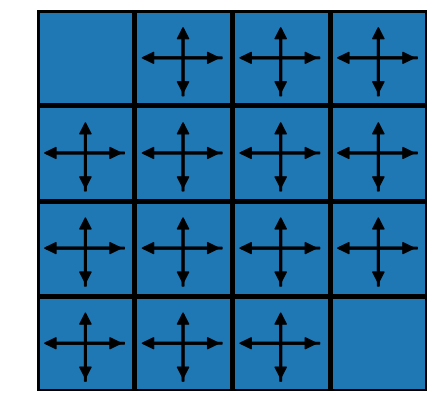

array([[  0., -14., -20., -22.],
       [-14., -18., -20., -20.],
       [-20., -20., -18., -14.],
       [-22., -20., -14.,   0.]])

In [7]:
values = evaluate_policy(random_policy)
draw_policy(random_policy)
values

In [8]:
#Policy improvement
#We can improve our random policy by selecting a new greedy policy
#pi'(s) = argmax_a Q_pi(s,a) = argmax_a sum_s' p(s'|s,a) [r(s'|s,a) + V_pi(s')]

def improve_policy(old_policy, values):
    improved_policy = defaultdict(list)
    for i in range(nrows):
        for j in range(ncols):
            current_state = (i,j)
            if current_state not in terminal_states:
                vals = {}

                for action, prob in get_actions(current_state, old_policy):
                    possible_state = get_possible_states_action(current_state, action)

                    vals[action] = (transition_model[possible_state,current_state,action] *\
                                                              (rewards_model[possible_state, current_state, action] + values[possible_state[0], possible_state[1]]))

                #improved_policy[current_state] = [np.argmax(vals)]
                #This gets the dictionary get (for us, an action) with the highest q value
                #print(current_state,vals)
                improved_policy[current_state] =[ max(vals,key=vals.get)]
    return improved_policy

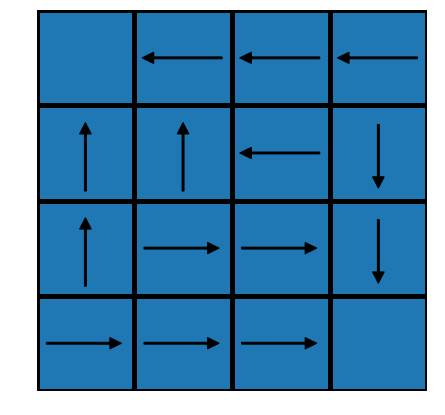

defaultdict(list,
            {(0, 1): [2],
             (0, 2): [2],
             (0, 3): [1],
             (1, 0): [0],
             (1, 1): [2],
             (1, 2): [1],
             (1, 3): [1],
             (2, 0): [0],
             (2, 1): [0],
             (2, 2): [1],
             (2, 3): [1],
             (3, 0): [0],
             (3, 1): [3],
             (3, 2): [3]})

In [9]:
improved_policy = improve_policy(random_policy, values)
draw_policy(improved_policy)
improved_policy

In [10]:
#Clearly our new policy is much better!!
evaluate_policy(improved_policy)

Converged after 3 iterations


array([[ 0., -1., -2., -3.],
       [-1., -2., -3., -2.],
       [-2., -3., -2., -1.],
       [-3., -2., -1.,  0.]])

In [11]:
#Policy iteration
#There's not much improvement in our current example, since we achieve optimal policy within 1 iteration, but this is just for theory.
#We want to find optimal policy via Evaluate->Improve->Evaluate->Improve ... etc

#We don't require input; start with random policy
def iterate_policy():
    random_policy = defaultdict(list)
    for i in range(nrows):
        for j in range(ncols):
            if (i,j) not in terminal_states:
                random_policy[(i,j)] = [0,1,2,3]
                
    policy_stable = False
    current_policy = random_policy
    while not policy_stable:
        values = evaluate_policy(current_policy)
        new_policy = improve_policy(current_policy,values)
        
        if new_policy == current_policy:
            policy_stable = True
        
        current_policy = new_policy
    
    return current_policy

Converged after 469 iterations
Converged after 3 iterations


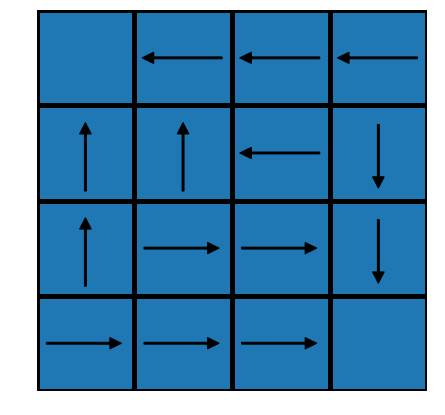

In [12]:
p = iterate_policy()
draw_policy(p)

In [13]:
#Value iteration
#Instead of having to do this iterative thing of evaluate->improve, we can 'improve over time' all at once
#We do this via value iteration: instead of updating each value at the next step based on the regular bellman equation, 
#we use the bellman optimality equation which includes a max instead of an expectaiton.

def value_iteration():
    values_old = np.zeros((nrows,ncols))
    values_new = np.zeros((nrows,ncols))

    for k in range(1000):
        for i in range(nrows):
            for j in range(ncols):
                current_state = (i,j)
                if current_state not in terminal_states:
                    vals = []
                    for action in range(num_actions):
                        possible_state = get_possible_states_action(current_state,action)
                        itval = transition_model[possible_state, current_state, action] *\
                        (rewards_model[possible_state, current_state, action] + 1 * values_old[possible_state[0], possible_state[1]])
                        vals.append(itval)

                    values_new[i,j] = np.max(vals)

        if np.sum(np.abs(values_old - values_new)) < 1e-10:
            print("Converged after %d iterations" % k)
            break
        values_old = np.copy(values_new)

    values = values_new

    improved_policy = defaultdict(list)
    for i in range(nrows):
        for j in range(ncols):
            current_state = (i,j)
            if current_state not in terminal_states:
                vals = {}

                for action in range(num_actions):
                    possible_state = get_possible_states_action(current_state, action)

                    vals[action] = (transition_model[possible_state,current_state,action] *\
                                                              (rewards_model[possible_state, current_state, action] + values[possible_state[0], possible_state[1]]))

                #improved_policy[current_state] = [np.argmax(vals)]
                #This gets the dictionary get (for us, an action) with the highest q value
                #print(current_state,vals)
                improved_policy[current_state] =[ max(vals,key=vals.get)]
                
    return values, improved_policy

In [14]:
v, p = value_iteration()

Converged after 3 iterations


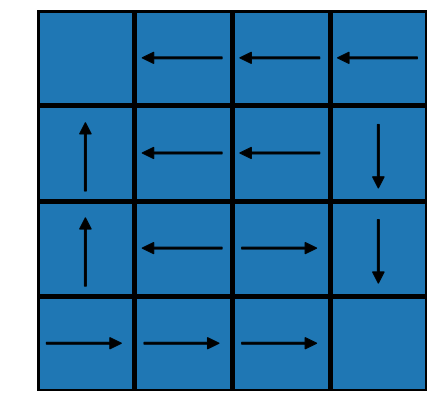

In [15]:
draw_policy(p)